In [2]:
!pip install dotenv

In [52]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from dotenv import load_dotenv
import numpy as np
import os

load_dotenv(override=True)

ORG_NAME = "preludetx"
PROJECT_NAME = "PreludeTx_Dotmatics_2024"
API_URL = f"https://dev.azure.com/{ORG_NAME}/{PROJECT_NAME}/_apis/wit/wiql?api-version=7.0"

AZURE_DEVOPS_PAT = os.getenv("AZURE_DEVOPS_PAT")
if not AZURE_DEVOPS_PAT:
    AZURE_DEVOPS_PAT = input("Enter your Azure DevOps PAT: ")

USERS = {
    "Trinh, Spencer <strinh@rchsolutions.com>": "Trinh, Spencer",
    "Genaro Scavello": "Genaro Scavello",
    "Raul Leal": "Raul Leal",
    "Amy Crossan": "Amy Crossan",
    "Min Wang": "Min Wang",
    "Jeff Edonick": "Jeff Edonick",
    "sukanya.r <sukanya.r@zifornd.com>": "Sukanya R",
    "Lakshmipriya Jayamoorthy <Lakshmipriya01.J@zifornd.com>": "Lakshmipriya Jayamoorthy",
    "Nithya Venkatesh <Nithya.V@zifornd.com>": "Nithya Venkatesh"
}

user_selection = widgets.SelectMultiple(
    options=list(USERS.keys()),
    description="Users:",
    style={'description_width': 'initial'},
    layout={'width': 'max-content'}
)


def fetch_work_items(user):
    wiql_query = {
        "query": f"""
        SELECT [System.Id], [System.ChangedDate], [System.CreatedDate], 
               [Microsoft.VSTS.Common.ClosedDate], [System.AssignedTo], 
               [Microsoft.VSTS.Common.ActivatedBy], [System.State], 
               [System.Title], [System.WorkItemType], 
               [Microsoft.VSTS.Scheduling.StoryPoints]
        FROM WorkItems
        WHERE [System.TeamProject] = '{PROJECT_NAME}' 
        AND ([Microsoft.VSTS.Common.ActivatedBy] = '{user}' OR [System.AssignedTo] = '{user}')
        ORDER BY [System.ChangedDate] DESC
        """
    }

    response = requests.post(API_URL, headers={"Content-Type": "application/json"}, 
                             auth=("", AZURE_DEVOPS_PAT), json=wiql_query)
    
    if response.status_code != 200:
        print(f"Error fetching work items for {user}: {response.json()}")
        return None

    work_items = response.json().get("workItems", [])
    if not work_items:
        print(f"No work items found for {user}")
        return None

    work_item_ids = ",".join(str(item["id"]) for item in work_items)

    fields = "System.Id,System.Title,System.AssignedTo,System.State,Microsoft.VSTS.Scheduling.StoryPoints,System.CreatedDate,Microsoft.VSTS.Common.ClosedDate,System.WorkItemType,Microsoft.VSTS.Common.ActivatedBy"
    details_url = f"https://dev.azure.com/{ORG_NAME}/{PROJECT_NAME}/_apis/wit/workitems?ids={work_item_ids}&fields={fields}&api-version=7.0"
    
    results = requests.get(details_url, auth=("", AZURE_DEVOPS_PAT))
    
    if results.status_code != 200:
        print(f"Error fetching work item details for {user}: {results.json()}")
        return None
    
    return results.json()["value"]


def analyze_and_plot(selected_users):
    all_data = []
    
    for user in selected_users:
        data = fetch_work_items(user)
        if not data:
            continue
        
        user_df = pd.DataFrame([{
            "ID": item["id"],
            "Title": item["fields"].get("System.Title", ""),
            "AssignedTo": USERS[user],
            "ActivatedBy": item["fields"].get("Microsoft.VSTS.Common.ActivatedBy", ""),
            "State": item["fields"].get("System.State", ""),
            "StoryPoints": item["fields"].get("Microsoft.VSTS.Scheduling.StoryPoints", 0),
            "CreatedDate": pd.to_datetime(item["fields"].get("System.CreatedDate", None)),
            "ClosedDate": pd.to_datetime(item["fields"].get("Microsoft.VSTS.Common.ClosedDate", None)),
            "WorkItemType": item["fields"].get("System.WorkItemType", ""),
        } for item in data])

        user_df["CycleTime"] = (user_df["ClosedDate"] - user_df["CreatedDate"]).dt.days
        all_data.append(user_df)
        
    # Combine data for all users
    if not all_data:
        print("No data to display.")
        return
    
    df = pd.concat(all_data, ignore_index=True)
    min_date = df['CreatedDate'].min().strftime('%Y-%m-%d')
    max_date = df['CreatedDate'].max().strftime('%Y-%m-%d')

    plt.figure(figsize=(10, 5))
    df.groupby("AssignedTo")["State"].value_counts().unstack().plot(kind="bar", stacked=True, colormap="viridis", figsize=(10, 6))
    plt.xlabel("Users")
    plt.ylabel("Number of Work Items")
    plt.title(f"Work Item State Distribution by User from {min_date} to {max_date}")
    plt.xticks(rotation=45)
    plt.legend(title="State")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

    df.dropna(subset=["CycleTime"], inplace=True)

    if not df.empty:
        plt.figure(figsize=(10, 5))
        
        users = list(selected_users)
        num_users = len(users)
        width = 2.5
    
        bins = np.histogram_bin_edges(df["CycleTime"], bins=10)
    
        for idx, user in enumerate(users):
            user_df = df[df["AssignedTo"] == USERS[user]]
            hist, _ = np.histogram(user_df["CycleTime"], bins=bins)
    
            # Offset bars for each user using width
            plt.bar(bins[:-1] + (idx - num_users / 2) * width, hist, width=width, alpha=0.7, label=USERS[user])
    
        plt.xlabel("Cycle Time (days)")
        plt.ylabel("Number of Work Items")
        plt.title(f"Cycle Time Distribution by User from {min_date} to {max_date}")
        plt.legend()
        plt.grid(axis="y", linestyle="--", alpha=0.7)
        plt.show()

In [53]:
display(user_selection)

SelectMultiple(description='Users:', layout=Layout(width='max-content'), options=('Trinh, Spencer <strinh@rchs…

<Figure size 1000x500 with 0 Axes>

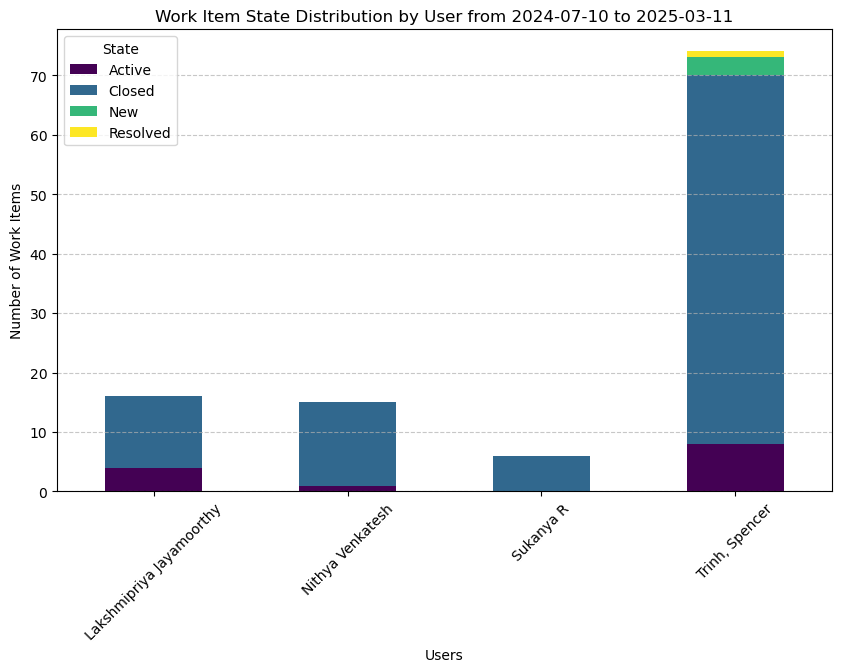

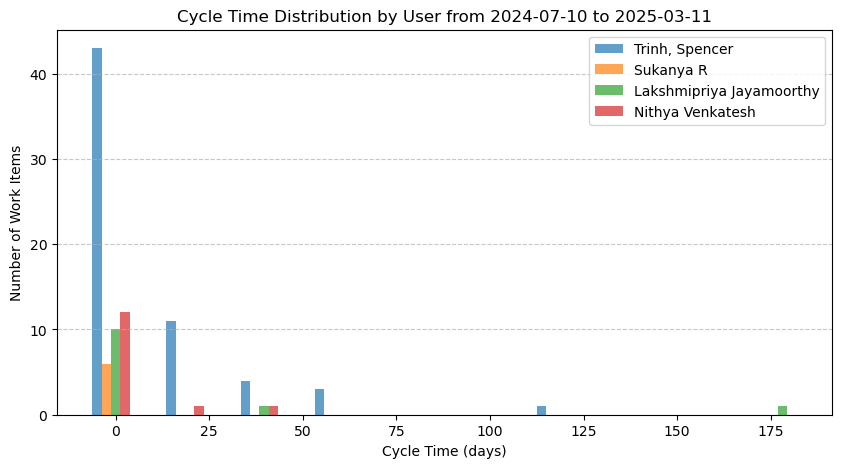

In [54]:
analyze_and_plot(list(user_selection.value) )